# 2D Gaussian Fit

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors

from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
import astropy.constants as const
from astropy.io import fits

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean
from astroML.plotting import scatter_contour

import os
import time
from corner import corner

import pickle

from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.stats import chi2

from tqdm import tqdm
from hdbscan import HDBSCAN
from scipy.stats import binned_statistic
from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

import sys
import time
import numpy as np
import scipy as sp
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
from matplotlib import gridspec,cm
from scipy import integrate, interpolate, special, stats, optimize
#from CosmoFunc import *
from scipy.linalg import lapack

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame
from DESI_functions import rz_table, FP_func, omega_m

/global/homes/s/sgmoore1/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

LightSpeed = 299792.458 #km/s
omega_m = 0.3121 #Flat LambdaCDM assumed for distance calcs
Hubble_Constant = 100.0

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '../'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_corr-20251030.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.5690596280100633e-05,122.32238811543634,10.869518800965125,N
55,SGA-2020 55,PGC1203

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

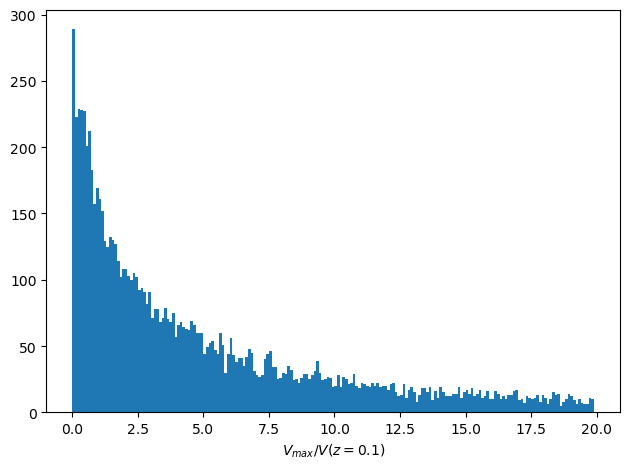

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

In [8]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.4

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [9]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '../'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [10]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [11]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [12]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [13]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [14]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Photometric corrections

### Survey offsets

In [15]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [16]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [17]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [18]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [19]:
# ##### Split the data into 3 regions z<=0.03 to be corrected to z=0.03, z>=0.1 to be corrected to z=0.1,
# ##### and the middle region to have no k-correction

# zg0_low = (sgatab['Z_DESI'] >= 0) & (sgatab['Z_DESI'] <= 0.03) #there are a couple below zero
# zg0_high = (sgatab['Z_DESI'] >= 0.1)

# kcorr_zg0_low = k_corr(sgatab['Z_DESI'][zg0_low], 
#                    [sgatab['G_MAG_SB26'][zg0_low], sgatab['R_MAG_SB26'][zg0_low], sgatab['Z_MAG_SB26'][zg0_low]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_low], sgatab['R_MAG_SB26_ERR'][zg0_low], sgatab['Z_MAG_SB26_ERR'][zg0_low]], 
#                    z_corr=0.03)

# kcorr_zg0_high = k_corr(sgatab['Z_DESI'][zg0_high], 
#                    [sgatab['G_MAG_SB26'][zg0_high], sgatab['R_MAG_SB26'][zg0_high], sgatab['Z_MAG_SB26'][zg0_high]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_high], sgatab['R_MAG_SB26_ERR'][zg0_high], sgatab['Z_MAG_SB26_ERR'][zg0_high]], 
#                    z_corr=0.1)


# kcorr = np.zeros((len(sgatab), 3))
# kcorr[zg0_low] = kcorr_zg0_low
# kcorr[zg0_high] = kcorr_zg0_high

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [20]:
temp_infile = open('../iron_internalDust_z0p1_mcmc_nokcorr.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [21]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [22]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [23]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z

In [24]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (based on ellipse fit shown below notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [25]:
sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value
sgatab['logV'] = np.log10(sgatab['V_0p4R26'])
sgatab['logV_ERR'] = 0.434*sgatab['V_0p4R26_ERR']/sgatab['V_0p4R26']

In [26]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John

spiral_boolean = sgatab['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = sgatab['MORPHTYPE_AI'] == 'Irregular'

VI_boolean = sgatab['JOHN_VI'].mask
morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean
# sgatab['GOOD_MORPH'] = morph_boolean

logvmin=1

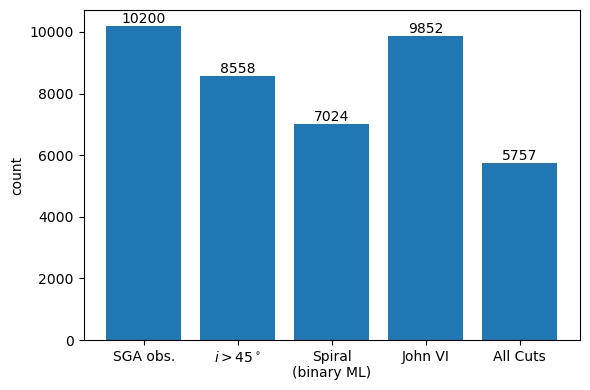

In [27]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    # 'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

In [28]:
caltab = sgatab[is_good_sga].to_pandas()
sgatab = sgatab.to_pandas()

# Apply the 2D Gaussian Fit (FP)

In [29]:
# Get some redshift-distance lookup tables
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()  ##redshift distance lookup tables. Can use astropy instead

## Set up weights for selection effects

In [30]:
# def TF_FN_func(params, logv, m, err_logv, err_m,
#                logvmin=None, logvmax=None,
#                Mmin=None):
#     """
#     Selection function for Tully-Fisher using perpendicular scatter.
#     Includes analytic integration over velocity limits.

#     params = [a, b, logV0, sigma_perp]
#     Mmin: (nd, N_galaxies)
#     """

#     a, b, logV0, sigma_perp = params
#     Ndbins, Ngal = Mmin.shape

#     dv = logvmax - logvmin

#     FN = np.zeros(Ngal)

#     for i in range(Ngal):

#         # Perpendicular variance (consistent with likelihood)
#         perp_sigma2 = (
#             (err_m[i]**2 + a**2 * err_logv[i]**2) / (1.0 + a**2)
#             + sigma_perp**2
#         )
#         perp_sigma = np.sqrt(perp_sigma2)

#         B = a / perp_sigma

#         pvals_bins = []

#         for j in range(Ndbins):

#             A = (Mmin[j, i] - b + a * logV0) / perp_sigma

#             # Evaluate u at velocity limits
#             u_min = A - B * logvmin
#             u_max = A - B * logvmax

#             # Analytic integral piece
#             term_min = u_min * stats.norm.cdf(u_min) + stats.norm.pdf(u_min)
#             term_max = u_max * stats.norm.cdf(u_max) + stats.norm.pdf(u_max)

#             integral_v = (term_min - term_max) / B

#             # Normalize by velocity width
#             integral_v /= dv

#             pvals_bins.append(integral_v)

#         FN[i] = np.mean(pvals_bins)

#     FN = np.maximum(FN, 1e-15)

#     return np.log10(FN)


In [31]:
def TF_perp_func(params, logdists, zobs, logv, m, err_logv, err_m, Sn, logvmin, sumgals=True, chi_squared_only=False):

    # unpack parameters
    a, b, logv0, sigma_int = params

    # model
    delta = m - (a * (logv - logv0) + b)

    # perpendicular residual
    denom = np.sqrt(1.0 + a**2)
    delta_perp = delta / denom

    # projected measurement variance
    sigma_perp2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)

    # total variance
    sigma_tot2 = sigma_perp2 + sigma_int**2

    # chi-squared
    chi2 = delta_perp**2 / sigma_tot2
    log_det = np.log(sigma_tot2)

    chi2 *= Sn
    log_det *= Sn

    if chi_squared_only:
        return chi2
    elif sumgals:
        return 0.5 * np.sum(chi2 + log_det)
    else:
        return 0.5 * (chi2 + log_det)

def TF_FP_func(params, logdists, zobs, logv, m,
               err_logv, err_m, Sn,
               logvmin=None,
               sumgals=True,
               chi_squared_only=False):
    """
    Perpendicular Tully-Fisher likelihood.

    params = [a, b, logV0, sigma_int]
        a, b        : slope and intercept
        logV0       : pivot velocity
        sigma_int   : intrinsic perpendicular scatter

    logdists : scalar (0.0 for fitting) or array (for PDF extraction)
    Sn       : selection weights
    """

    a, b, logV0, sigma_int = params

    # Precompute slope geometry
    denom = np.sqrt(1.0 + a**2)

    # -------------------------------------------------
    # CASE 1: Scalar logdists (normal fit)
    # -------------------------------------------------
    if np.isscalar(logdists):

        # Model magnitude
        m_model = a * (logv - logV0) + b

        # Perpendicular residual
        delta = m - m_model
        delta_perp = delta / denom

        # Project measurement errors perpendicular
        sigma_meas2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)

        # Total variance
        sigma_tot2 = sigma_meas2 + sigma_int**2

        chi2 = delta_perp**2 / sigma_tot2
        log_det = np.log(sigma_tot2)

        # Apply selection weighting
        chi2 *= Sn
        log_det *= Sn

        if chi_squared_only:
            return chi2

        if sumgals:
            return 0.5 * np.sum(chi2 + log_det)
        else:
            return 0.5 * (chi2 + log_det)

    # -------------------------------------------------
    # CASE 2: Distance grid mode (PDF extraction)
    # -------------------------------------------------
    else:

        logdists = np.asarray(logdists)

        # Shift magnitudes by distance
        m_shifted = m[None, :] + 5.0 * logdists[:, None]

        # Model magnitude
        m_model = a * (logv - logV0) + b
        delta = m_shifted - m_model[None, :]

        delta_perp = delta / denom

        sigma_meas2 = (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)
        sigma_tot2 = sigma_meas2 + sigma_int**2

        chi2 = delta_perp**2 / sigma_tot2[None, :]
        log_det = np.log(sigma_tot2)[None, :]

        # Apply selection weighting along the galaxy axis
        chi2 *= Sn[None, :]
        log_det *= Sn[None, :]

        return 0.5 * (chi2 + log_det)

def TF_FN_func(params, logv, m, err_logv, err_m,
               logvmin=None, logvmax=None,
               Mmin=None):
    """
    Fully vectorized selection function for Tully-Fisher.

    params = [a, b, logV0, sigma_perp]
    Mmin: (nd, N_galaxies)
    """

    a, b, logV0, sigma_perp = params

    # Shapes
    nd, Ngal = Mmin.shape

    dv = logvmax - logvmin

    # -------------------------------------------------
    # Perpendicular variance (shape: Ngal)
    # -------------------------------------------------
    perp_sigma2 = (
        (err_m**2 + a**2 * err_logv**2) / (1.0 + a**2)
        + sigma_perp**2
    )
    perp_sigma = np.sqrt(perp_sigma2)              # (Ngal,)

    # -------------------------------------------------
    # Define A and B
    # -------------------------------------------------
    # A has shape (nd, Ngal)
    A = (Mmin - b + a * logV0) / perp_sigma[None, :]

    # B has shape (Ngal,)
    B = a / perp_sigma

    # -------------------------------------------------
    # Evaluate u at velocity limits
    # -------------------------------------------------
    # Shapes: (nd, Ngal)
    u_min = A - B[None, :] * logvmin
    u_max = A - B[None, :] * logvmax

    # -------------------------------------------------
    # Analytic integral pieces
    # -------------------------------------------------
    term_min = u_min * stats.norm.cdf(u_min) + stats.norm.pdf(u_min)
    term_max = u_max * stats.norm.cdf(u_max) + stats.norm.pdf(u_max)

    # Velocity integral (nd, Ngal)
    integral_v = (term_min - term_max) / B[None, :]

    # Normalize by velocity width
    integral_v /= dv

    # -------------------------------------------------
    # Average over distance bins
    # -------------------------------------------------
    FN = np.mean(integral_v, axis=0)   # (Ngal,)

    FN = np.maximum(FN, 1e-15)

    return np.log10(FN)


In [32]:
##compute comoving distances for galaxies in our sample
dz_sample_full = sp.interpolate.splev(sgatab["Z_DESI_CMB"], dist_spline)
dz_sample = sp.interpolate.splev(caltab["Z_DESI_CMB"].to_numpy(), dist_spline)

##define min and max redshift cuts
zmin, zmax = np.min(caltab['Z_DESI_CMB']), np.max(caltab['Z_DESI_CMB'])

##cube of luminosity distance (Volume proxy) for min and max redshifts included in survey (Selection effects, for Sn calculation)
Vmin, Vmax = (1.0+zmin)**3*sp.interpolate.splev(zmin, dist_spline)**3, (1.0+zmax)**3*sp.interpolate.splev(zmax, dist_spline)**3  


##compute max luminosity distance at which each individual galaxy would be observable based on the diameter limited sample
theta_min=np.radians(20*u.arcsec).value
print(theta_min)
Dlim = ((caltab["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + caltab["Z_DESI_CMB"].to_numpy())**2 ### since distance should be in Mpc
zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##compute max redshift that each galaxy would be observable (based of luminosity)
Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##compute selection effect weighting to account for incompleteness in sample caused by redshift and magnitude cuts (based off fraction of survey volume where galaxy with magnitude m_r could be observed) 
# Sn = np.ones(len(zlim))
data_fit = caltab  ##copy input dataframe with spirals removed (to prep for fitting algorithm) 
badcount = len(caltab)  ##initialise outlier count for fitting algorithm
print(len(data_fit), badcount)


# Fit the TFR
ii = 0
converged = False  ##initialise convergence flag for fitting algorithm
start = time.time()
while not converged: ##FP fitting algorithm (see Howlett et. al., 2022 for details)

    ii += 1
    dz_sample_fit = sp.interpolate.splev(data_fit["Z_DESI_CMB"].to_numpy(), dist_spline) ##compute cluster comoving distance for fitting subset(subset of dz_cluster_nosirals)
    Dlim = ((data_fit["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + data_fit["Z_DESI_CMB"].to_numpy())**2  ##max observable luminsity distance of galaxy for fitting subset(subset of prev. Dlim)
    zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##max observable redshift of galaxy for fitting subset(subset of prev. zlim)
    Snfit = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##compute selection effect weighting (Sn) for fitting subset(subset of prev. Sn)
    # Snfit = np.ones(len(zlim)) ##affectively removes weighting parameter Sn

    avals = (-10, -4)        # slope
    bvals = (-25, -15)      # intercept
    v0vals = (1.6, 2.2)     # logV0
    sintvals = (0.01, 1.0)  # intrinsic scatter
    bounds = (avals, bvals, v0vals, sintvals)

    TFparams = sp.optimize.differential_evolution(TF_perp_func, bounds=bounds,
                                                  args=(0.0,  # placeholder for logdists
                                                        data_fit["Z_DESI_CMB"].to_numpy(),  # redshifts
                                                        data_fit["logV"].to_numpy(),        # observed log velocities
                                                        data_fit["R_ABSMAG_SB26"].to_numpy(),  # observed magnitudes
                                                        data_fit["logV_ERR"].to_numpy(),    # velocity errors
                                                        data_fit["R_MAG_SB26_ERR_CORR"].to_numpy(),  # magnitude errors
                                                        Snfit,
                                                        logvmin),
                                                  maxiter=10000, tol=1e-6, disp=False)

    #computes (x-xmean)C_n^{-1}(x-xmean)^T for all TF galaxies
    chi_squared = (1/Sn)*TF_perp_func(TFparams.x, 0.0,
                                  zobs=caltab["Z_DESI_CMB"].to_numpy(),
                                  logv=caltab["logV"].to_numpy(),
                                  m=caltab["R_ABSMAG_SB26"].to_numpy(),
                                  err_logv=caltab["logV_ERR"].to_numpy(),
                                  err_m=caltab["R_MAG_SB26_ERR_CORR"].to_numpy(),
                                  Sn=Sn,
                                  logvmin=logvmin,
                                  sumgals=False,
                                  chi_squared_only=True)


    ##compute p-value of fit for all calibration galaxies (seven parameters: a, b, m , logv, sig_m, sig_v, cov)
    dof = 4
    pvals = stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(caltab) - dof)) 

    ##reassign data_fit with galaxies that have pvalue>0.01 (not outliers)
    data_fit = caltab.drop(caltab[pvals < 0.01].index).reset_index(drop=True)
    badcountnew = len(np.where(pvals < 0.01)[0]) ##count of all removed outliers
    converged = True if badcount == badcountnew else False  ##update converged to end loop if the number of outliers hasn't changed
    print(TFparams.x, np.sum(chi_squared), len(data_fit), stats.chi2.isf(0.01, np.sum(chi_squared)/(len(caltab) - dof)), np.sum(chi_squared)/(len(caltab) - dof), badcount, badcountnew, converged)
    print(f'Reduced chi^2 value = {np.sum(chi_squared) / (len(caltab) - dof):.4f}')
    badcount = badcountnew

print(time.time()-start)


9.696273622190721e-05
5757 5757
[ -7.03669854 -19.85543019   2.08156782   0.06798033] 6814.415797576812 5650 7.169944872862545 1.1844977920349056 5757 107 False
Reduced chi^2 value = 1.1845
[ -6.99667664 -17.1165054    1.69084866   0.05891207] 8226.715236667267 5630 7.829410499200729 1.4299870044615448 107 127 False
Reduced chi^2 value = 1.4300
[ -6.99381891 -17.55740929   1.75331712   0.05804628] 8394.576762381574 5630 7.904623481528201 1.4591650899324828 127 127 True
Reduced chi^2 value = 1.4592
2.1949923038482666


In [33]:
#### Now compute the chi^2 values to determine outliers in the full sample

zmin, zmax = np.min(sgatab['Z_DESI_CMB']), np.max(sgatab['Z_DESI_CMB'])
Vmin, Vmax = (1.0+zmin)**3*sp.interpolate.splev(zmin, dist_spline)**3, (1.0+zmax)**3*sp.interpolate.splev(zmax, dist_spline)**3  

Dlim = ((sgatab["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + sgatab["Z_DESI_CMB"].to_numpy())**2 ### since distance should be in Mpc
zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##compute max redshift that each galaxy would be observable (based of luminosity)
Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##compute selection effect weighting to account for incompleteness in sample caused by redshift and magnitude cuts (based off fraction of survey volume where galaxy with magnitude m_r could be observed) 

chi_squared = (1/Sn)*TF_perp_func(TFparams.x, 0.0,
                              zobs=sgatab["Z_DESI_CMB"].to_numpy(),
                              logv=sgatab["logV"].to_numpy(),
                              m=sgatab["R_ABSMAG_SB26"].to_numpy(),
                              err_logv=sgatab["logV_ERR"].to_numpy(),
                              err_m=sgatab["R_MAG_SB26_ERR_CORR"].to_numpy(),
                              Sn=Sn,
                              logvmin=logvmin,
                              sumgals=False,
                              chi_squared_only=True)
pvals = stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(caltab) - dof)) 

outlier_boolean = pvals < 0.01

In [34]:
a = TFparams.x[0]
b = TFparams.x[1]

logV0 = TFparams.x[2]
sigma_int = TFparams.x[3]
print(a,b, sigma_int)

-6.993818913340991 -17.55740929345261 0.05804628141961149


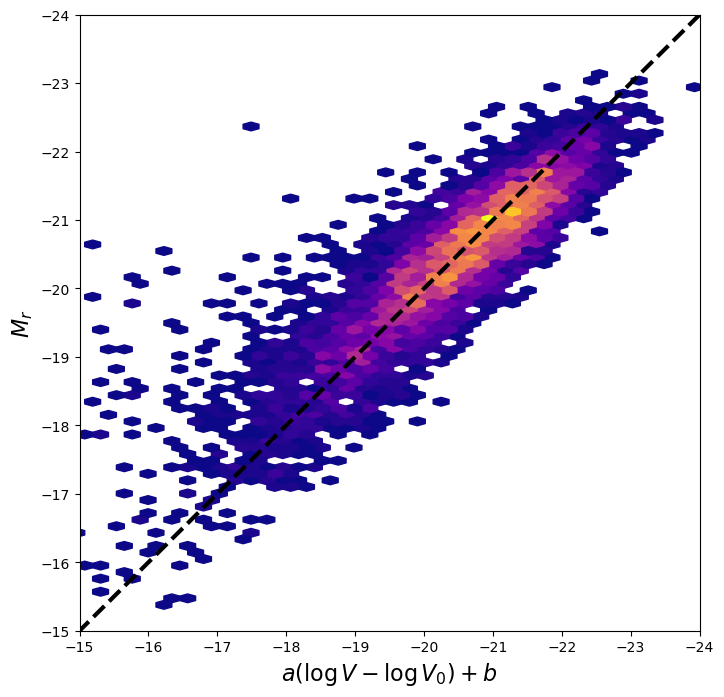

In [35]:
plt.figure(figsize=(8,8))
plt.hexbin(x=a*(data_fit['logV']-logV0) +b, y = data_fit['R_ABSMAG_SB26'], cmap='plasma', mincnt=1, gridsize=(50,50), )
plt.xlabel(r'$a (\log V - \log V_0) + b$', fontsize=16)
plt.ylabel(r'$M_r$', fontsize=16)
plt.plot([-30,-10], [-30,-10], 'k--', lw=3, zorder=5)

plt.xlim(-15,-24)
plt.ylim(-15,-24)
plt.show()

/global/homes/s/sgmoore1/.local/lib/python3.10/site-packages/astroML/plotting/scatter_contour.py:96: UserWarning: linewidths is ignored by contourf
  contours = ax.contourf(H.T, levels, extent=extent, **contour_args)


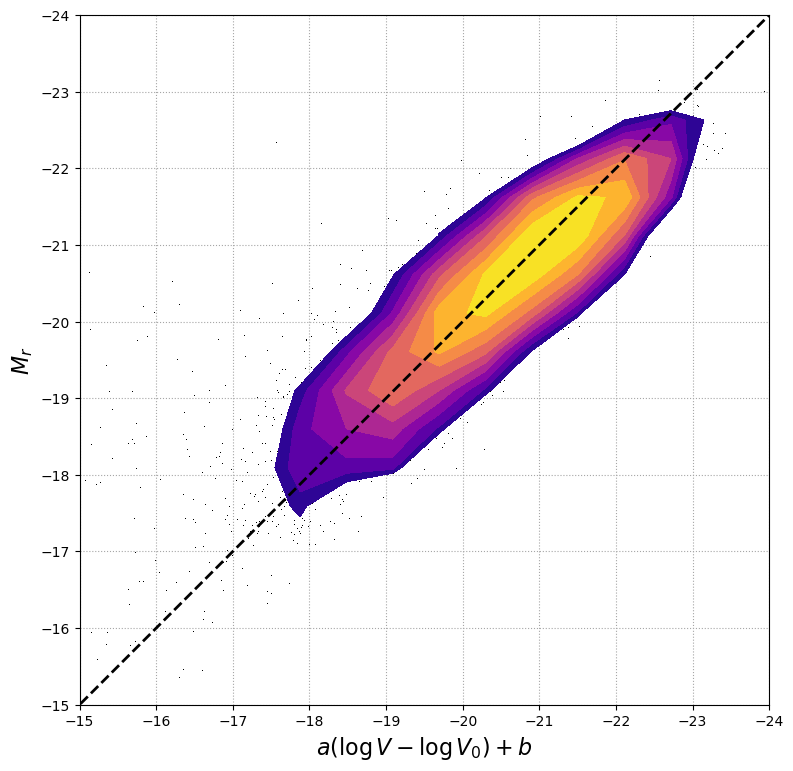

In [36]:
# Predicted vs observed y
xdata = a*(data_fit['logV']-logV0) + b  # predicted y
ydata = data_fit['R_ABSMAG_SB26']       # observed y

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-15, -24)
ax.set_ylim(-15, -24)

# Scatter + Gaussian-like density contours
scatter_contour(xdata, ydata, threshold=25, log_counts=True, ax=ax,
               histogram2d_args=dict(bins=20),
               plot_args=dict(marker=',', linestyle='none', color='black'),
               contour_args=dict(cmap=plt.cm.plasma, linewidths=2))

# y=x reference line
ax.plot([-25, -14], [-25, -14], 'k--', lw=2, label='y=x')

# Labels
ax.set_xlabel(r'$a (\log V - \log V_0) + b$', fontsize=16)
ax.set_ylabel(r'$M_r$', fontsize=16)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', color='0.65')
plt.tight_layout()
plt.show()


In [37]:
#recalculate Sn so that it is recorded for all galaxies (including dupes and outliers)
dz = sp.interpolate.splev(np.array(sgatab["Z_DESI_CMB"])/LightSpeed, dist_spline)  ##compute galaxy comoving distances
# dz_cluster = sp.interpolate.splev(data["zcmb_group"], dist_spline)   ##compute cluster/group comoving distances
Dlim = ((sgatab["D26_kpc"]/1e3)/ np.tan(theta_min))*(1.0 + sgatab["Z_DESI_CMB"].to_numpy())**2 
zlim = sp.interpolate.splev(Dlim, lumred_spline)  ##compute max redshift that each galaxy would be observable (based of luminosity)
sgatab["Sn"] = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin))) ##recompute and save Sn values to dataframe
# sgatab["Sn"] = np.ones(len(sgatab))

TFparams = TFparams.x ##save best fit TF parameters
# print(len(data), TFparams)

# norm1, norm2 = 1.0+FPparams[0]**2+FPparams[1]**2, 1.0+FPparams[1]**2+0**2*(FPparams[0]**2+FPparams[1]**2)-2.0*FPparams[0]*0  ##square of eq. B2 
# k=0
# fac1 =  k*FPparams[0]**2 + k*FPparams[1]**2 - FPparams[0]
# sigmar2 =  1.0/norm1*FPparams[5]**2 +      FPparams[1]**2/norm2*FPparams[6]**2 + fac1**2/(norm1*norm2)*FPparams[7]**2    ##eq. B3

In [38]:
#write best fit FP parameters to py
TFparam_df = pd.DataFrame({'avals':[TFparams[0]],
						   'bvals':[TFparams[1]],
						   'logv_mean':[TFparams[2]],
						   'sig':[TFparams[3]],
						  })

The bounds on our likelihood are given by
$$ v_{min} = \log(10)$$
$$ v_{max} = \log(1000)$$
based on our velocity cuts, and then based on the diameter-limited sample, we have the following magnitude limit:

$$ M_\mathrm{lim} = \mu_{\rm iso} - 5 \log_{10}(\theta_{\rm min}) - 5 \log_{10}(D_L / 10\ \mathrm{pc})$$

where $\mu = 26$ based on the isophote we use, $D_L$ = luminosity distance in pc

In [39]:
# Fit the log-distance ratios
dmin, dmax, nd = -1.5, 1.5, 1001  # log-distance ratio limits
dbins = np.linspace(dmin, dmax, nd, endpoint=True)  # bins for log-distance shifts

# Compute 'true' distance for each galaxy for each log-distance shift
# Shape: (nd, N_galaxies)
d_H = 10.0**(-dbins)[:, None] * dz_sample_full[None, :]  # multiply each galaxy by each dbin

# Luminosity distance in parsecs for each shift
D_L = d_H * (1.0 + sgatab["Z_DESI_CMB"].to_numpy())[None, :] * 1e6  # Mpc -> pc

# Minimum absolute magnitude as function of distance shift
mu_iso = 26.0  # mag/arcsec^2
theta_min = 20.0  # arcsec
# Shape: (nd, N_galaxies)
Mmin = mu_iso - 5.0 * np.log10(theta_min) - 5.0 * np.log10(D_L / 10.0)

# Velocity limits (can also be functions of dbins if needed)
logvmin = np.log10(10)
logvmax = np.log10(1000)

# Compute log-likelihood using the TF_FP_func
loglike = TF_FP_func(
    TFparams,
    dbins,
    sgatab["Z_DESI_CMB"].to_numpy(),  # observed redshifts
    sgatab["logV"].to_numpy(),        # observed log velocities
    sgatab["R_ABSMAG_SB26"].to_numpy(),  # observed magnitudes
    sgatab["logV_ERR"].to_numpy(),
    sgatab["R_MAG_SB26_ERR_CORR"].to_numpy(),
    Sn=sgatab['Sn'].to_numpy(),
    # Sn=np.ones(len(sgatab)),
    logvmin=logvmin,
    sumgals=False
)

/tmp/ipykernel_1758387/1578733283.py:16: RuntimeWarning: invalid value encountered in log10
  Mmin = mu_iso - 5.0 * np.log10(theta_min) - 5.0 * np.log10(D_L / 10.0)


In [40]:
# Compute selection function accounting for diameter cut and distance shifts
start = time.time()
FNvals = TF_FN_func(
    TFparams,
    sgatab["logV"].to_numpy(),
    sgatab["R_ABSMAG_SB26"].to_numpy(),
    sgatab["logV_ERR"].to_numpy(),
    sgatab["R_MAG_SB26_ERR_CORR"].to_numpy(),
    logvmin=logvmin,
    logvmax=logvmax,
    Mmin=Mmin  # now 2D: (nd, N_galaxies)
)
print(time.time() - start)

3.6890623569488525


In [41]:
# Convert to the PDF for logdistance
logP_dist = -1.5*np.log(2*np.pi) - loglike - FNvals[None, :] 

ddiff = np.log10(d_H[:-1, :]) - np.log10(d_H[1:, :])
valdiff = np.exp(logP_dist[1:, :]) + np.exp(logP_dist[:-1, :])  # (nd-1, Ngal)
norm = 0.5 * np.sum(valdiff * ddiff, axis=0)  # (Ngal,)
logP_dist -= np.log(norm)[None, :]  # (nd, Ngal)

/tmp/ipykernel_1758387/1874263973.py:4: RuntimeWarning: invalid value encountered in log10
  ddiff = np.log10(d_H[:-1, :]) - np.log10(d_H[1:, :])


In [42]:
# Calculate the mean and variance of the gaussian, then the skew
mean = np.sum(dbins[0:-1,None]*np.exp(logP_dist[0:-1])+dbins[1:,None]*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 ##trapazoidal integral of logR* likelihood over dbins for each galaxy (mean of gaussian)
err = np.sqrt(np.sum(dbins[0:-1,None]**2*np.exp(logP_dist[0:-1])+dbins[1:,None]**2*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - mean**2) 
gamma1 = (np.sum(dbins[0:-1,None]**3*np.exp(logP_dist[0:-1])+dbins[1:,None]**3*np.exp(logP_dist[1:]), axis=0)*(dbins[1]-dbins[0])/2.0 - 3.0*mean*err**2 - mean**3)/err**3
gamma1 = np.where(gamma1 > 0.99, 0.99, gamma1)
gamma1 = np.where(gamma1 < -0.99, -0.99, gamma1)
delta = np.sign(gamma1)*np.sqrt(np.pi/2.0*1.0/(1.0 + ((4.0 - np.pi)/(2.0*np.abs(gamma1)))**(2.0/3.0)))
scale = err*np.sqrt(1.0/(1.0 - 2.0*delta**2/np.pi))
loc = mean - scale*delta*np.sqrt(2.0/np.pi)
alpha = delta/(np.sqrt(1.0 - delta**2))


In [43]:
##save log-distance values
print(mean, err, alpha)
sgatab["LOGDIST"] = mean ##mean of weighted likelihood gaussian 
sgatab["LOGDIST_ERR"] = err ##varience of weighted likelihood gaussian
sgatab["LOGDIST_alpha"] = alpha ##skew of weighted likelihood gaussian
print(len(sgatab))
TFparam_df['MEAN_LOGDIST'] = np.mean(sgatab["LOGDIST"])

[ 0.0456804  -0.00070626  0.03539067 ...  0.05218624 -0.02847594
  0.102162  ] [0.6154898  0.80402817 0.33107905 ... 0.53780081 0.24496074 0.74056697] [-0.58909214  0.16225902 -0.10383331 ... -0.5242377   0.0088493
 -0.94657746]
10200


In [52]:
# Create a single column to denote which objects should be used for cosmological analysis
sgatab['OUTLIER'] = outlier_boolean
sgatab['MAIN'] = ~sgatab['OUTLIER'] & morph_boolean

## Compute the corresponding mu values from the logdist ratios

First, we will compute a mu and logdist value analytically from the TFR the way we did before:

In [53]:
sgatab = Table.from_pandas(sgatab)

In [54]:
#-------------------------------------------------------------------------------
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(sgatab['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(sgatab['Z_DESI_CMB'][i]), 
                               sgatab['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

sgatab['MU_ZCMB_ERR'] = mu_err

# sgatab['R_ABSMAG_SB26_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['MU_ZCMB_ERR'].value**2)

100%|██████████| 10200/10200 [00:13<00:00, 761.70it/s]


In [55]:
sgatab['R_ABSMAG_SB26_TF_calc']= a*(sgatab['logV']-logV0) + b

sgatab['R_ABSMAG_SB26_TF_ERR_calc'] = np.nan
sgatab['R_ABSMAG_SB26_TF_ERR_STAT_calc'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(sgatab))):
    
    v_random = rng.normal(sgatab['V_0p4R26'][i], 
                          sgatab['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(sgatab['V_0p4R26'][i]), 
    #                          0.434*sgatab['V_0p4R26_ERR'][i]/sgatab['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = a*(np.log10(v_random[v_random > 0]) - logV0) + b
    # Ms_stat = slope*(logv_random - V0) + ZP

    sgatab['R_ABSMAG_SB26_TF_ERR_STAT_calc'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    sgatab['R_ABSMAG_SB26_TF_ERR_calc'][i] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR_STAT_calc'][i]**2 + sigma_int**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
sgatab['R_ABSMAG_SB26_TF_ERR_SYS_calc'] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR_calc']**2 - sgatab['R_ABSMAG_SB26_TF_ERR_STAT_calc']**2)
################################################################################

100%|██████████| 10200/10200 [00:05<00:00, 1951.12it/s]


In [56]:
### do the calculations with the best-fit parameters the way we did before

sgatab['R_ABSMAG_SB26_TF_calc']= a*(sgatab['logV']-logV0) + b

sgatab['MU_TF_calc'] = sgatab['R_MAG_SB26_CORR'] - sgatab['R_ABSMAG_SB26_TF_calc']
sgatab['MU_TF_ERR_calc'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['R_ABSMAG_SB26_TF_ERR_calc']**2)
sgatab['LOGDIST_calc'] = 0.2*(sgatab['MU_ZCMB'] - sgatab['MU_TF_calc'])
sgatab['LOGDIST_ERR_calc'] = 0.2*np.sqrt(sgatab['MU_ZCMB_ERR']**2 + sgatab['MU_TF_ERR_calc']**2)

sgatab['MU_TF'] = sgatab['MU_ZCMB'] - 5*sgatab['LOGDIST']
sgatab['MU_TF_ERR'] = np.sqrt(sgatab['MU_ZCMB_ERR']**2 + (5*sgatab['LOGDIST_ERR']**2))

# Calculate logdistance ratios

## Compute distance modulus based on our TFR

## $\eta$ v. redshift

In [57]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

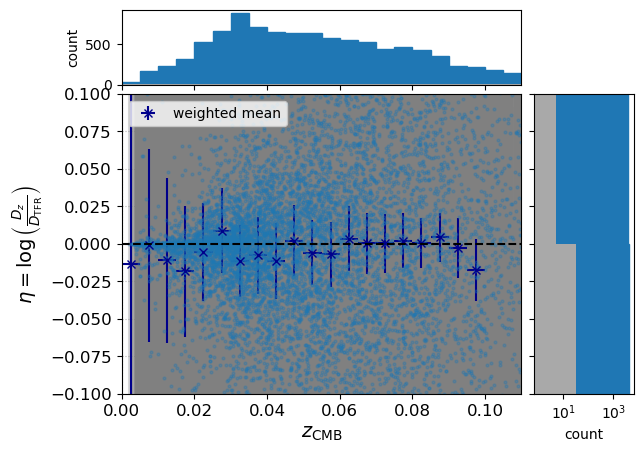

In [58]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean


fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

# ax.errorbar(sgatab['Z_DESI_CMB'][sample2], 
#              sgatab['LOGDIST'][sample2], 
#              xerr=sgatab['ZERR_DESI'][sample2], 
#              yerr=sgatab['LOGDIST_ERR'][sample2],
#              fmt='.', 
#              color='gray',
#              alpha=0.1, 
#              ecolor='gray')

ax.errorbar(sgatab['Z_DESI_CMB'][sample1], 
             sgatab['LOGDIST'][sample1], 
             xerr=sgatab['ZERR_DESI'][sample1], 
             yerr=sgatab['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3,
             color='tab:blue',
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              color='tab:blue',
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1),
              color='tab:blue',
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

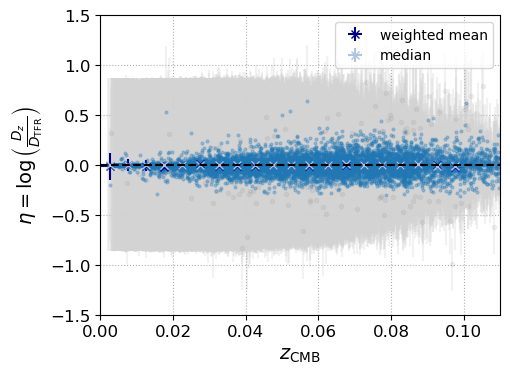

In [59]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(sgatab['Z_DESI_CMB'][sample2], 
             sgatab['LOGDIST'][sample2], 
             xerr=sgatab['ZERR_DESI'][sample2], 
             yerr=sgatab['LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(sgatab['Z_DESI_CMB'][sample1], 
             sgatab['LOGDIST'][sample1], 
             xerr=sgatab['ZERR_DESI'][sample1], 
             yerr=sgatab['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3,
             color='tab:blue',
             ecolor='lightgray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

# Plot the median
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')

# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
# ax.set_xlim((0, 0.2))
ax.set_ylim((-1.5, 1.5))
# ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

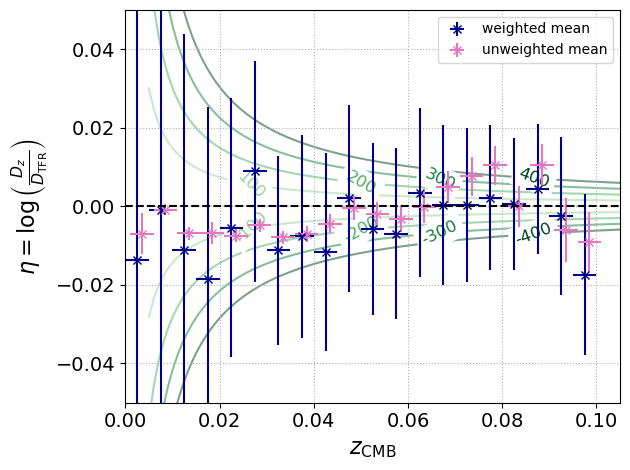

In [60]:
plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.105, 0.005)
_dz = 0.5*np.diff(_zbins)
_zc = 0.5*(_zbins[1:] + _zbins[:-1])


N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=False)
plt.errorbar(zc+0.001, y_avg, xerr=dz, yerr=y_std, fmt='x', color='tab:pink', label='unweighted mean')
#-------------------------------------------------------------------------------
# PV lines (code taken from Cullen)
c = const.c.to('km/s')
velarray = np.arange(-400, 401, 100)
zarray = np.linspace(0.005, 0.21, 200)

dzarray = cosmo.comoving_distance(zarray).value
dharray = cosmo.comoving_distance(np.outer(1.0/(1.0 + velarray/c.value), 
								  (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/c.value)
ycoord = np.array([deltamarray[i,j] for i, j in enumerate(coord)])

colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

for v in range(len(velarray)):
    col = plt.cm.Greens(colors[v])

    plt.plot(zarray, deltamarray[v,:], 
             color=col, 
             linestyle='-', 
             alpha=0.5, 
             zorder=0)

    if (v != 4):
        plt.text(xcoord[v]/c.value, ycoord[v], 
                 labels[v], 
                 color=col, 
                 fontsize=12, 
                 rotation=rotation[v], 
                 ha="center", 
                 va="center", 
                 bbox=dict(boxstyle="square", ec="w", fc="w"), 
                 zorder=1)

# Line at eta = 0
plt.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)
#-------------------------------------------------------------------------------

plt.grid(ls=':')

# plt.vlines([0.03, 0.1], -0.05, 0.05, colors='gray', linestyles='dashed')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=16)
plt.ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', 
           fontsize=16)

plt.ylim((-0.05, 0.05))
# plt.ylim((-0.13, 0.13))
plt.xlim((0, 0.105))
# plt.xlim((0, 0.2))

plt.legend();

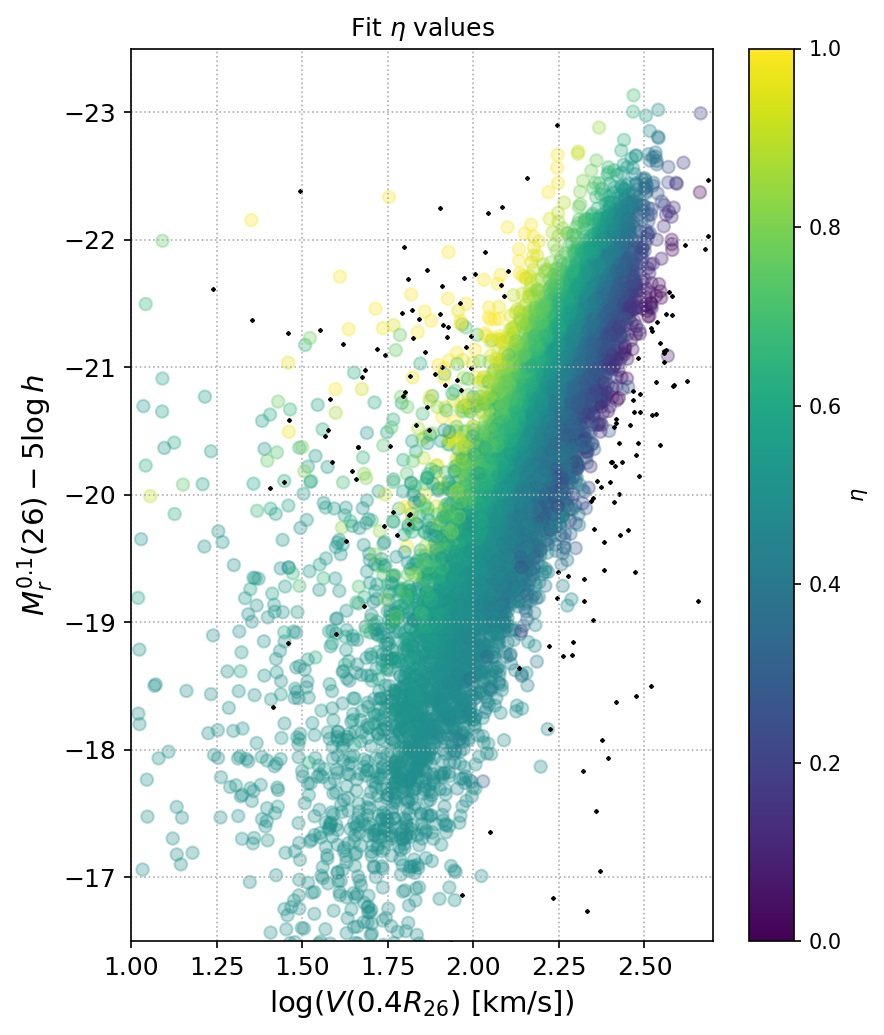

In [61]:
### Comparing methods of calculating logdist values:

plt.figure(figsize=(6,7), tight_layout=True, dpi=150, facecolor='none')

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')


sample = ~outlier_boolean# & morph_boolean
plt.scatter(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample],
            c=sgatab['LOGDIST'][sample], vmin=-0.3, vmax=0.3, alpha=0.3)
plt.scatter(np.log10(sgatab['V_0p4R26'][~sample]), 
             sgatab['R_ABSMAG_SB26'][~sample],marker='x', s=2, c='k')
plt.colorbar(label=r'$\eta$')

# sample = ~outlier_boolean_alt & outlier_boolean
# plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
#              sgatab['R_ABSMAG_SB26'][sample], 
#              xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
#              yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
#              fmt='.', 
#              markersize=4, 
#              alpha=0.2, 
#              ecolor='gray')




# plt.xlim([0.5, 3.1])
# plt.ylim([-12.25, -24.5])

plt.xlim([1, 2.7])
plt.ylim([-16.5, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);
plt.title(r'Fit $\eta$ values')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

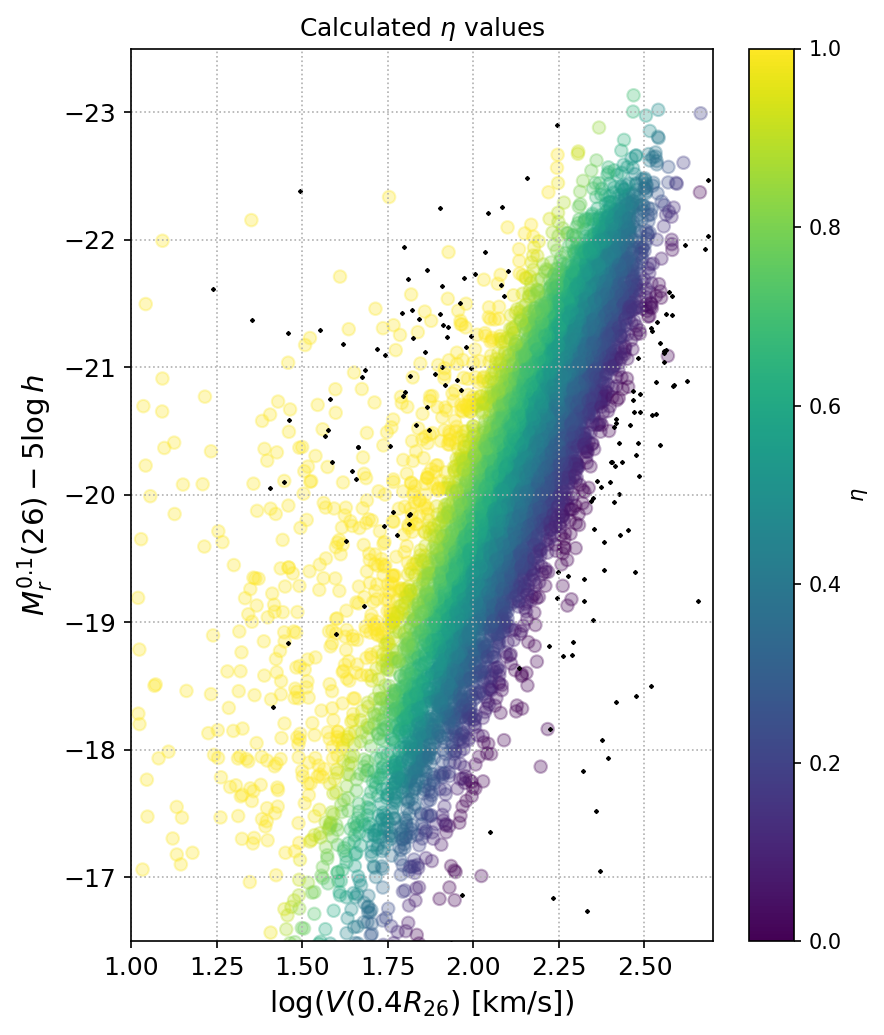

In [62]:
### Comparing methods of calculating logdist values:

plt.figure(figsize=(6,7), tight_layout=True, dpi=150, facecolor='none')

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')


sample = ~outlier_boolean# & morph_boolean
plt.scatter(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample],
            c=sgatab['LOGDIST_calc'][sample], vmin=-0.3, vmax=0.3, alpha=0.3)
plt.scatter(np.log10(sgatab['V_0p4R26'][~sample]), 
             sgatab['R_ABSMAG_SB26'][~sample],marker='x', s=2, c='k')
plt.colorbar(label=r'$\eta$')

# sample = ~outlier_boolean_alt & outlier_boolean
# plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
#              sgatab['R_ABSMAG_SB26'][sample], 
#              xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
#              yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
#              fmt='.', 
#              markersize=4, 
#              alpha=0.2, 
#              ecolor='gray')




# plt.xlim([0.5, 3.1])
# plt.ylim([-12.25, -24.5])

plt.xlim([1, 2.7])
plt.ylim([-16.5, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);
plt.title(r'Calculated $\eta$ values')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

(-0.25, 0.25)

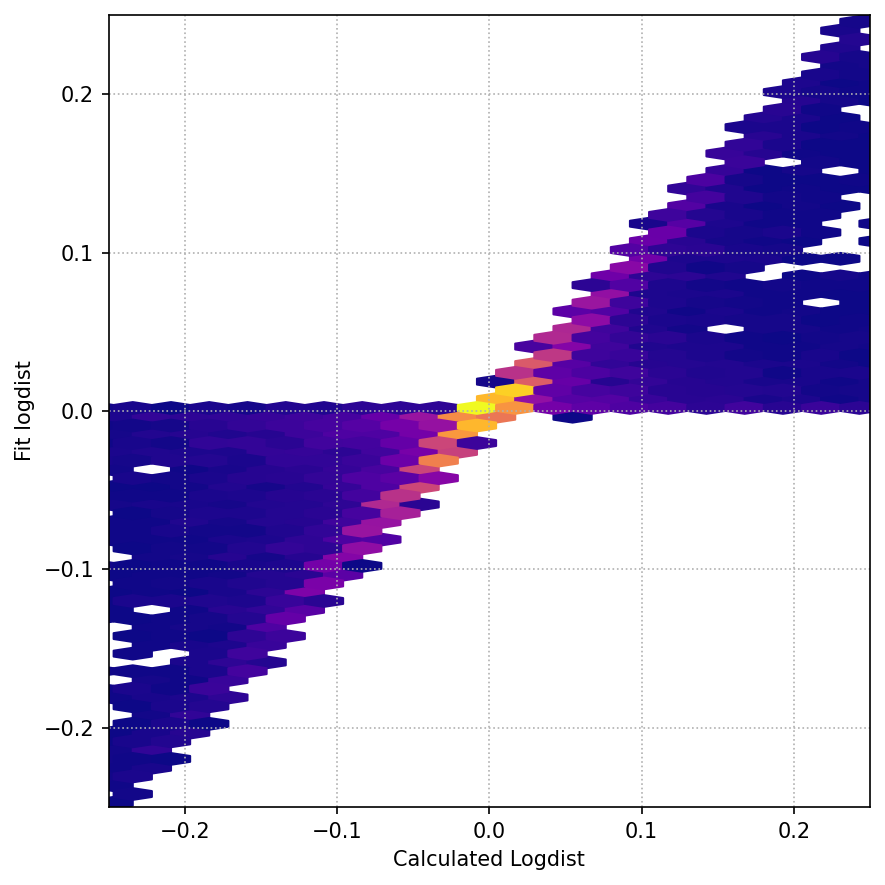

In [63]:
plt.figure(figsize=(6,6), tight_layout=True, dpi=150, facecolor='none')

plt.grid(ls=':')

sample = ~outlier_boolean# & morph_boolean
plt.hexbin(sgatab['LOGDIST_calc'][sample], sgatab['LOGDIST'][sample], cmap='plasma', mincnt=1, gridsize=(100,100),)
plt.xlabel('Calculated Logdist')
plt.ylabel('Fit logdist')
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)

(-0.5, 0.7)

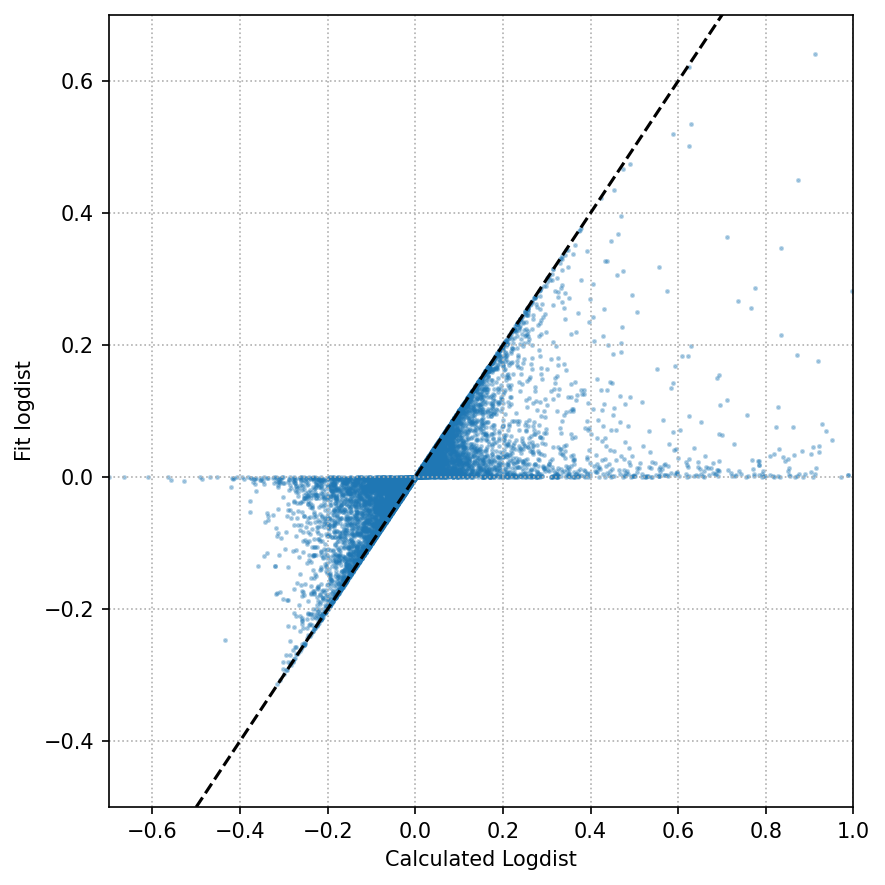

In [64]:
plt.figure(figsize=(6,6), tight_layout=True, dpi=150, facecolor='none')

plt.grid(ls=':')

sample = ~outlier_boolean# & morph_boolean
# plt.hexbin(sgatab['LOGDIST_calc'][sample], sgatab['LOGDIST'][sample], cmap='plasma', mincnt=1, gridsize=(100,100),)
plt.scatter(sgatab['LOGDIST_calc'][sample], sgatab['LOGDIST'][sample], alpha=0.3, s=2)
plt.plot([-0.5,1], [-0.5,1],'k--')
plt.xlabel('Calculated Logdist')
plt.ylabel('Fit logdist')
plt.xlim(-0.7,1)
plt.ylim(-0.5,0.7)

(0.020072771735074376, 0.640753757493465)

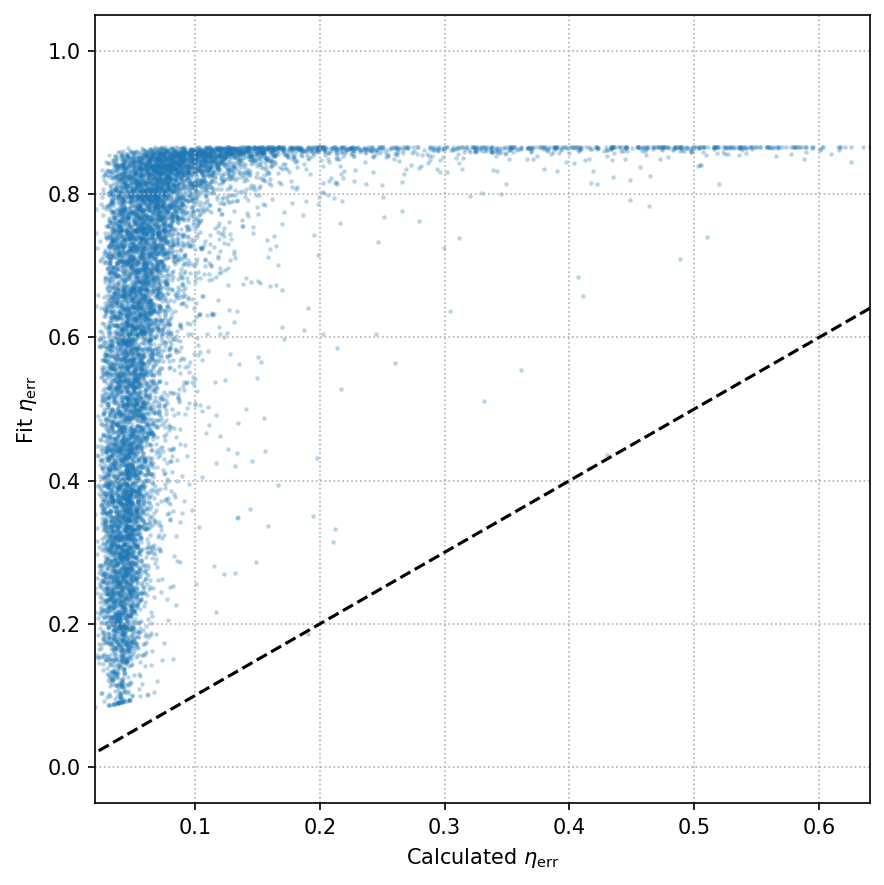

In [65]:
#### comparison of the uncertainties in eta:

plt.figure(figsize=(6,6), tight_layout=True, dpi=150, facecolor='none')

plt.grid(ls=':')

sample = ~outlier_boolean# & morph_boolean
plt.scatter(sgatab['LOGDIST_ERR_calc'][sample], sgatab['LOGDIST_ERR'][sample], alpha=0.2, s=2)
plt.plot([0,1], [0,1],'k--')
plt.xlabel(r'Calculated $\eta_{\rm err}$ ')
plt.ylabel(r'Fit $\eta_{\rm err}$ ')
plt.xlim(np.min(sgatab['LOGDIST_ERR_calc']),np.max(sgatab['LOGDIST_ERR_calc']))
# plt.ylim(-0.25,0.25)

In [133]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,logV,logV_ERR,GOOD_MORPH,Sn,LOGDIST,LOGDIST_ERR,LOGDIST_alpha,OUTLIER,MAIN,MU_ZCMB_ERR,R_ABSMAG_SB26_TF_calc,R_ABSMAG_SB26_TF_ERR_calc,R_ABSMAG_SB26_TF_ERR_STAT_calc,R_ABSMAG_SB26_TF_ERR_SYS_calc,MU_TF_calc,MU_TF_ERR_calc,LOGDIST_calc,LOGDIST_ERR_calc,MU_TF,MU_TF_ERR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,,,,,,,mag,,
float64,bytes16,bytes23,int64,float64,float64,bytes4,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes29,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,1

In [66]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = a
# hdr['M_ERR'] = slope_err
hdr['0PT'] = b
# hdr['0PT_ERR'] = ZP_err
hdr['logV0'] = logV0
hdr['SIG'] = sigma_int
# hdr['SIG_ERR'] = np.sqrt(cov_tfr[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [136]:
# sgatab.remove_column('GOOD_MORPH')

In [67]:
table_hdu = fits.BinTableHDU(data=sgatab)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('/pscratch/sd/s/sgmoore1/TF/cats/SGA_iron_2dGaussian.fits', 
             overwrite=True)

In [68]:
# hdul.writeto('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_v10.fits', 
#              overwrite=True)